# Analiza szeregu czasowego na przykładzie danych ze stacji Veturilo w Warszawie

### Wykonana predykcja dla 48h

**Zbierano ogólnodostępne dane co 5 minutu e serwisu Veturilo na temat liczby dostępnych rowerów w czasokresie 10.07-04.08.2020**

Autor: *Marian Witkowski* - https://www.linkedin.com/in/marianwitkowski/

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True)

warnings.filterwarnings("ignore")

In [70]:
df = pd.read_csv("bikes.csv", sep=';', header=None, parse_dates=True)
df.columns = ['ts','station','qnty']
df.ts = pd.to_datetime(df.ts, format='%Y-%m-%d %H:%M:%S')
df.station = df.station.astype('int')
df.qnty = df.qnty.replace("?", np.NaN).fillna(method='ffill').astype('int8')

## Pobranie informacji tylko dla wybranej stacji (Racławicka-Żwirki i Wigury)

In [71]:
df_probe = df[(df.station==2585346)]
df_probe = df_probe.reset_index(drop=True).sort_values('ts')

In [72]:
df_probe

,ts,station,qnty
0,2020-07-10 18:55:00,2585346,7
1,2020-07-10 19:00:00,2585346,7
2,2020-07-10 19:05:00,2585346,7
3,2020-07-10 19:10:00,2585346,7
4,2020-07-10 19:15:00,2585346,9
...,...,...,...
7362,2020-08-05 08:50:00,2585346,13
7363,2020-08-05 08:55:00,2585346,13
7364,2020-08-05 09:00:00,2585346,13
7365,2020-08-05 09:05:00,2585346,13


## Wykres dostępności rowerów oraz średnia krocząca 4-godzinowa

In [74]:
trace0 = go.Scatter(
   x = df_probe.ts,
   y = df_probe.qnty,
   name='Oryg'
)

trace1 = go.Scatter(
   x = df_probe.ts,
   y = df_probe.qnty.rolling(48).mean(),
   name='Śr. krocząca 4h'
)

data = [trace0, trace1]
layout = go.Layout(title = "", xaxis = {'title':'Data'}, yaxis = {'title':'Liczba rowerów'}, width=1000, height=800)
fig = go.Figure(data = data, layout = layout)
iplot(fig)

# Ograniczenie zakresu docelowego dat do 3.08 w celu późniejszego porównania z danymi rzeczywistymi

In [75]:
from fbprophet import Prophet

In [76]:
df_predict = df_probe[df_probe.ts<'2020-08-03 00:00:00']
del(df_predict['station'])
df_predict.reset_index(inplace=True, drop=True)
df_predict.columns = ['ds','y']
df_predict

,ds,y
0,2020-07-10 18:55:00,7
1,2020-07-10 19:00:00,7
2,2020-07-10 19:05:00,7
3,2020-07-10 19:10:00,7
4,2020-07-10 19:15:00,9
...,...,...
6675,2020-08-02 23:35:00,2
6676,2020-08-02 23:40:00,2
6677,2020-08-02 23:45:00,5
6678,2020-08-02 23:50:00,5


## Analiza czasu czasowego za pomocą biblioteki Prophet i predykcja kolejnych 48h

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


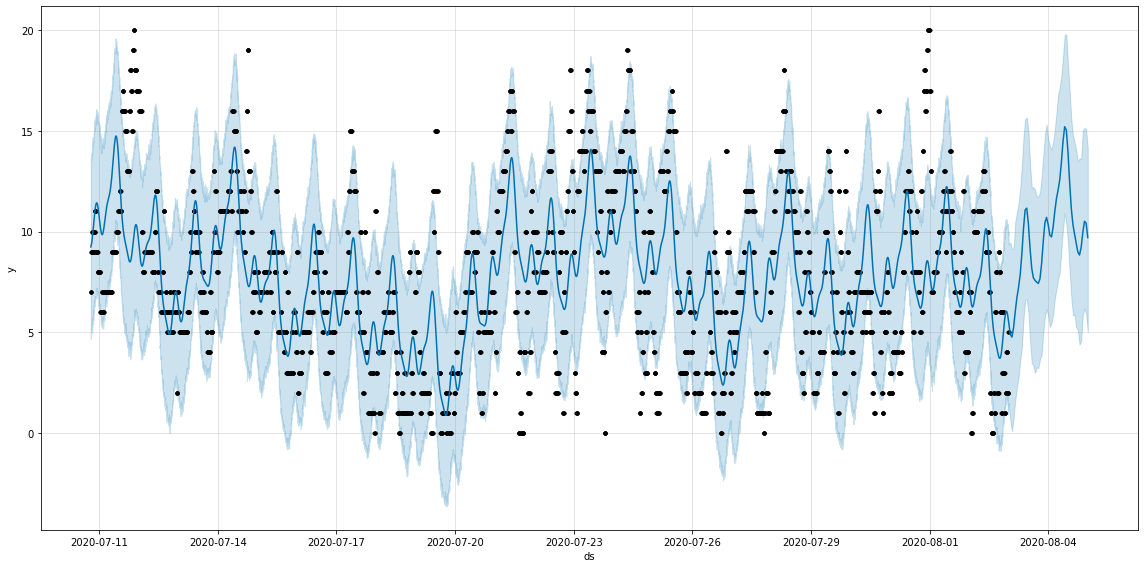

In [77]:
m = Prophet().fit(df_predict)
future = m.make_future_dataframe(periods=48, freq='H')
forecast = m.predict(future)
m.plot(forecast, figsize=(16,8), uncertainty=True)
plt.show()

## Wizualizacja trendu i składników szeregu czasowego

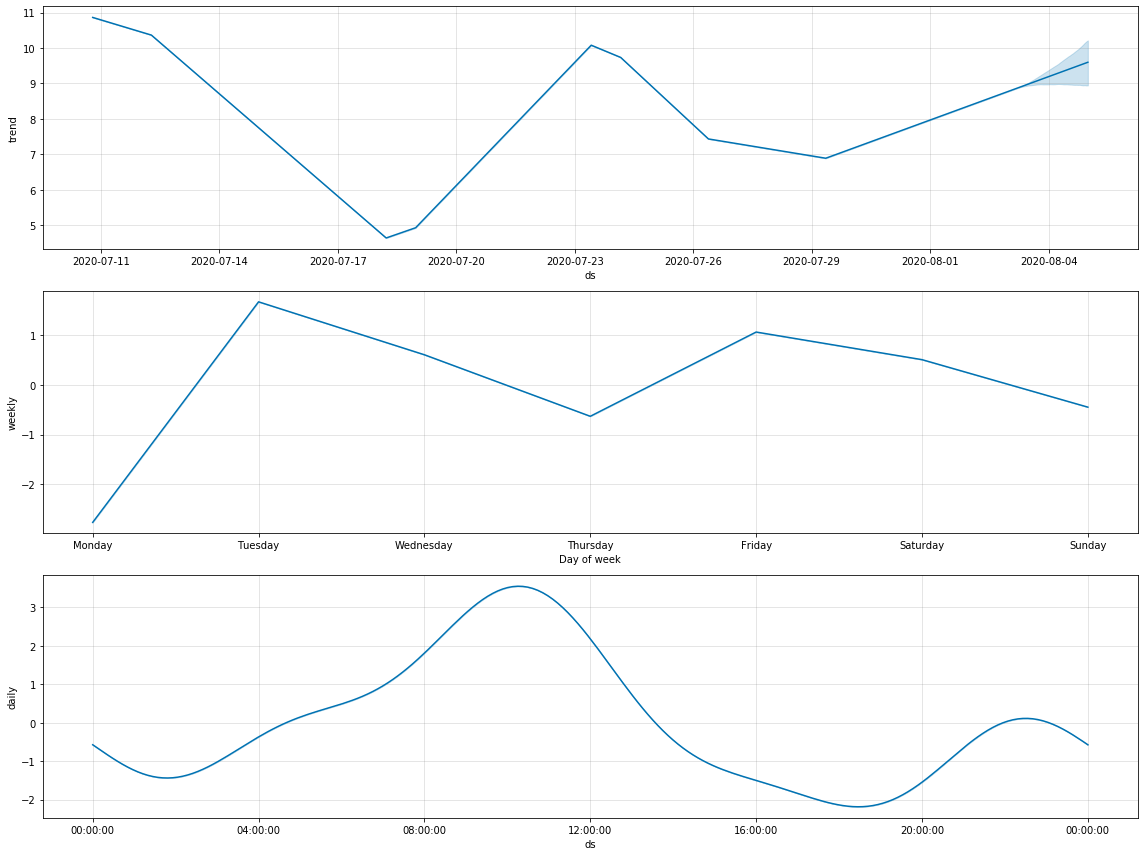

In [78]:
m.plot_components(forecast, figsize=(16,12), weekly_start=1)
plt.show()

## Pobranie danych rzeczywistych z prognozowanego czasokresu

In [80]:
df_future = df_probe[(df_probe.ts>='2020-08-03')&(df_probe.ts<'2020-08-05')].set_index('ts')
df_future

,station,qnty
ts,,
2020-08-03 00:00:00,2585346,5
2020-08-03 00:05:00,2585346,5
2020-08-03 00:10:00,2585346,5
2020-08-03 00:15:00,2585346,6
2020-08-03 00:20:00,2585346,6
...,...,...
2020-08-04 23:35:00,2585346,5
2020-08-04 23:40:00,2585346,5
2020-08-04 23:45:00,2585346,5


## Pobranie danych predykcyjnych

In [81]:
df_tmp = forecast[ ['ds', 'yhat', 'yhat_lower', 'yhat_upper'] ]
df_tmp.set_index('ds', inplace=True)
df_tmp = df_tmp.loc["2020-08-03":"2020-08-04"]
df_tmp.head()

,yhat,yhat_lower,yhat_upper
ds,,,
2020-08-03 00:55:00,4.901491,0.622670,9.461745
2020-08-03 01:55:00,4.762727,0.088183,9.138804
2020-08-03 02:55:00,5.242399,0.763617,9.175168
2020-08-03 03:55:00,6.027782,1.614253,10.485205
2020-08-03 04:55:00,6.715629,2.244147,10.948577


In [82]:
df_res = pd.concat([df_future, df_tmp], axis=1)
df_res

,station,qnty,yhat,yhat_lower,yhat_upper
2020-08-03 00:00:00,2585346,5,NaN,NaN,NaN
2020-08-03 00:05:00,2585346,5,NaN,NaN,NaN
2020-08-03 00:10:00,2585346,5,NaN,NaN,NaN
2020-08-03 00:15:00,2585346,6,NaN,NaN,NaN
2020-08-03 00:20:00,2585346,6,NaN,NaN,NaN
...,...,...,...,...,...
2020-08-04 23:35:00,2585346,5,NaN,NaN,NaN
2020-08-04 23:40:00,2585346,5,NaN,NaN,NaN
2020-08-04 23:45:00,2585346,5,NaN,NaN,NaN
2020-08-04 23:50:00,2585346,5,NaN,NaN,NaN


## Porównanie danych rzeczywistych z predykcją dla prognozowanego czasokresu

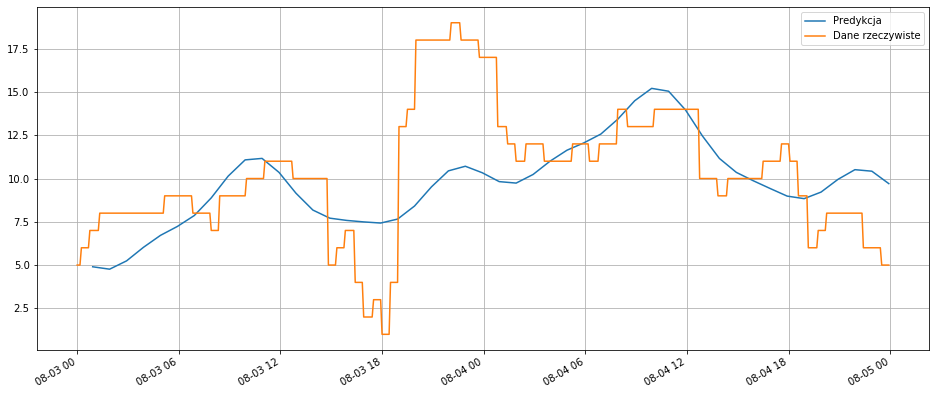

In [83]:
df_res.yhat[~df_res.yhat.isna()].plot()
df_res.qnty.plot(grid=True, figsize=(16,7))
plt.legend(['Predykcja','Dane rzeczywiste'])
plt.show()

## Dostępność rowerów jako wykres typu heatmap

In [84]:
df_heat = df_probe.reset_index()
df_heat['hour'] = df_heat['ts'].apply(lambda s: str(s)[11:13]).astype('int')
df_heat['day'] = df_heat['ts'].apply(lambda s: str(s)[:10])
df_heat.head()

,index,ts,station,qnty,hour,day
0,0,2020-07-10 18:55:00,2585346,7,18,2020-07-10
1,1,2020-07-10 19:00:00,2585346,7,19,2020-07-10
2,2,2020-07-10 19:05:00,2585346,7,19,2020-07-10
3,3,2020-07-10 19:10:00,2585346,7,19,2020-07-10
4,4,2020-07-10 19:15:00,2585346,9,19,2020-07-10


In [85]:
df_heat = pd.pivot_table(df_heat, index='hour',columns='day', values='qnty')

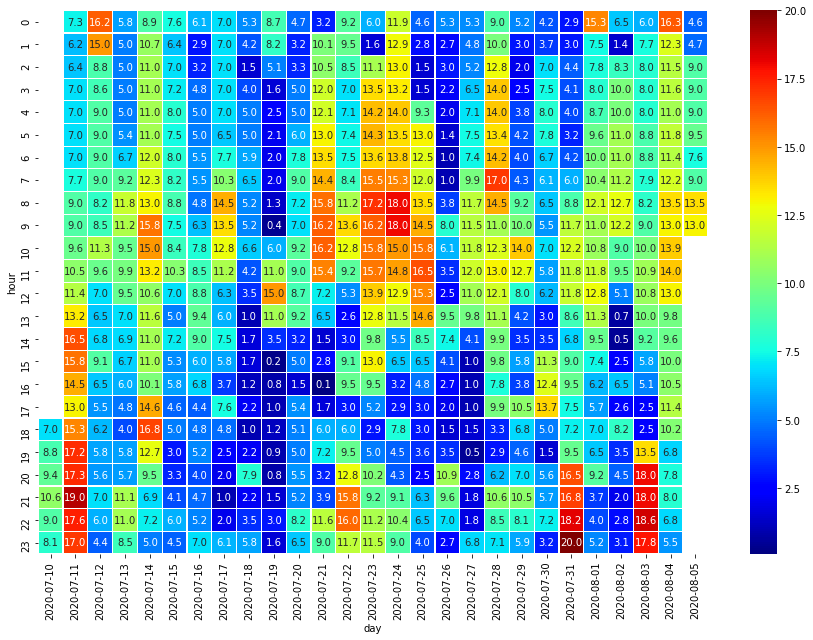

In [86]:
plt.figure(figsize=(15,10))
sns.heatmap(df_heat, annot=True, fmt='.1f', linewidth=0.1, cmap='jet')
plt.show()